# Как улучшить работу приложения Procrastinate Pro+

# Описание проекта

В развлекательном приложении Procrastinate Pro+ вложены крупные расходы в рекламу, однако последние несколько месяцев компания терпит убытки. 

### Цель исследования: 
определить причины убытков и наметить шаги для выхода в плюс.

### План работы:
- предобработка данных
- задать функции для расчёта и анализа LTV, ROI, удержания и конверсии
- провести исследовательский анализ данных
- рассчитать и проанализировать маркетинговые показатели
- оценить окупаемость рекламы
- сделать вывод по исследованию

Данные для анализа - это данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года.

## ОПИСАНИЕ ДАННЫХ
Имеется в доступе три датасета. 

Файл **visits_info_short.csv хранит лог сервера с информацией о посещениях сайта**, 

**orders_info_short.csv — информацию о заказах**, 

**costs_info_short.csv — информацию о расходах на рекламу**.


Структура **visits_info_short.csv**:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.


Структура **orders_info_short.csv**:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.


Структура **costs_info_short.csv**:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.


In [154]:
# загрузим необходимые бибилиотеки

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

### Шаг 1. Загрузите данные и подготовьте их к анализу

In [155]:
# загружаем данные
try:
    sessions, orders, ad_costs = (
     pd.read_csv('visits_info_short.csv'), # хранит лог сервера с информацией о посещениях сайта
     pd.read_csv('orders_info_short.csv'), # информацию о заказах
     pd.read_csv('costs_info_short.csv'), # информацию о расходах на рекламу
 )
except:
    sessions, orders, ad_costs = (
     pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv'), 
     pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv'), 
     pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv'), 
 )

**Информация о посещениях**

In [156]:
sessions.head(3) # проверим ДФ c посещением

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


In [157]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Изменим названия столбцов на строчную букву и поставим _ для правильного названия и непрерывности 

In [158]:
new_columns = {'User Id':'user_id','Region': 'region','Device':'device','Channel': 'channel', 'Session Start':'session_start', 'Session End': 'session_end'}
sessions.columns = sessions.columns = sessions.columns.map(new_columns.get)

Преобразуем данные о времени

In [159]:
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
sessions['session_end'] = pd.to_datetime(sessions['session_end'])

In [160]:
sessions.head(3) # проверяем как изменились названия

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


In [161]:
sessions.info() # проверим на наличие пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [162]:
sessions.duplicated().sum()

0

**Информация о заказах**

In [163]:
orders.head()# проверим ДФ с заказами

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Необходимо так же изменить названия колонок

In [164]:
new1_columns = {'User Id':'user_id','Event Dt': 'event_dt','Revenue':'revenue'}
orders.columns = orders.columns = orders.columns.map(new1_columns.get)

Преобразуем данные о времени

In [165]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [166]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [167]:
orders.head(3)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99


In [168]:
orders.duplicated().sum()

0

**Расходы на рекламу**

In [169]:
# проверим ДФ с расходами на рекламу
ad_costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Изменим название колонки Channel

In [170]:
new2_columns = {'dt':'dt','Channel':'channel', 'costs':'costs'}
ad_costs.columns = ad_costs.columns = ad_costs.columns.map(new2_columns.get)

In [171]:
#сделаем преобразование данных о времени
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

In [172]:
ad_costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [173]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [174]:
ad_costs.duplicated().sum()

0

### Мини вывод
- ДФ visits содержит 309901 строку и 6 столбцов, 
- ДФ orders содержит 40212 строк и 3 столбца, 
- ДФ costs содержит 1800 строки и 3 столбца. Все ДФ были проверены на наличие пропусков данных и явные дубликаты. 

Пропуски и дубликаты не обнаружены.

## Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

### Подготовим функцию get_profiles() для получения профилей пользователей

In [175]:
def get_profiles(sessions, orders, ad_costs):
    # Шаг 1. Передадим в функцию расчета профиля данные о рекламных затратах (фрейм ad_costs)
    
    # сортируем сессии по id пользователя и дате для того,чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # вернем все данные из индекса в колонки                                           
               )
    # определим дату первого посещеня 
    # и начало месяца первого посещения - они понадобятся нам при когортном анализе
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    profiles['week'] = profiles['first_ts'].astype('datetime64[W]')
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    # Шаг 2. К данным о рекламных затратах добавим количества привлеченных пользователей
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    # Шаг 3. Найдем среднюю стоимость привлечения пользователя
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # Шаг 4. Присоединим данные к профилям пользователей информацию о средней стоимости привлечения в день привлечения пользователя из нужного источника
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # органические пользователи будут стоить 0
    
    return profiles

**Создаем профили пользователей**

In [176]:
profiles = get_profiles(sessions, orders, ad_costs)

In [177]:
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,week,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,2019-10-02 00:07:44,False,0.230769


### Подготовим функцию get_retention() для расчета показателя Retention Rate (RR - удержание пользователя, то есть сколько пользователей воспользовались продуктом или услугой в последующие периоды)

будем подавать в качестве аргументов подготовленные профили пользователей, таблицу с визитами на сайт, момент анализа, горизонт анализа и вариант, когда мы не игнорируем горизонт анализа)

In [178]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Подготовим функцию get_conversion() для расчета показателя конверсии (это показатель, который описывает соотношение пользователей, совершивших желаемое действие, к общему числу посетителей или пользователей, выраженное в процентах)

In [179]:
def get_conversion(
    profiles,  
    orders, 
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Шаг 1. Получить пользовательские профили и данные о заказах
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Найти дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    ) 
    # Шаг 3. Добавить данные о заказах в профили
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )
    # Шаг 4. Рассчитать лайфтайм для каждого заказа

    result_raw['lifetime'] = (
        result_raw['event_dt'].dt.date - result_raw['dt']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    
     # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Подготовим функцию get_ltv() для расчета лайфтайма (или "пожизненная ценность» клиента), а также сразу ROI и CAC.

LTV - Общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок. 

In [180]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Подготовим функции для построения графиков:

#### filter_data() — для сглаживания данных,

In [181]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### plot_retention() — для построения графика Retention Rate и его динамики

In [182]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### plot_conversion() — для построения графика конверсии

In [183]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()



#### plot_ltv_roi() — для визуализации LTV и ROI

In [184]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()



## Минивыводы:

Задали функции для расчёта и анализа LTV, ROI, удержания и конверсии: get_profiles(), get_retention(), get_conversion(), get_ltv() и для создания графиков.

## Шаг 3. Исследовательский анализ данных

### 3 Составим профили пользователей. 


In [185]:
# Вызываем функцию get_profiles с аргументами visits, orders, costs и получаем профили пользователей
profiles = get_profiles(sessions, orders, ad_costs)

In [186]:
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,week,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,2019-10-02 00:07:44,False,0.230769


In [187]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   week              150008 non-null  datetime64[ns]
 8   payer             150008 non-null  bool          
 9   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(1), int64(1), object(4)
memory usage: 11.6+ MB


##### Мы составили профили пользователей. Получено 150008 уникальных профилей пользователей.

### 3.1 Определим минимальную и максимальную даты привлечения пользователей.


In [188]:
# определим доступный интервал привлечения пользователей
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()

print(min_analysis_date, max_analysis_date)


2019-05-01 2019-10-27


Таким образом, мы вычислили, что у нас представленны данные пользователей в период с 1 мая 2019 года по 27 октября 2019 года.

In [189]:
# зададим горизонт анализа и посчитаем максимальную дату привлечения
analysis_horizon =  14 
observation_date = max_analysis_date 
ignore_horizon = False
if not ignore_horizon:
    observation_date = max_analysis_date - timedelta(
        days=analysis_horizon - 1
    )# ваш код здесь

print(observation_date)

2019-10-14


По условиям задания горизонт событий определен как 2 недели, т.е. 14 дней. Поэтому **максимальная дата для привлечения данных в исследование равна 14 октября 2019 года** и она же будет считаться как observation_date, т.к. мы учитываем горизонт анализа.

### 3.2 Определим, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [190]:
# Подсчитаем количество пользователей для каждой страны
sessions_region = profiles['region'].value_counts()


In [191]:
sessions_region

United States    100002
UK                17575
France            17450
Germany           14981
Name: region, dtype: int64

In [192]:
# Подсчитаем количество платящих пользователей по странам
count_cost_region = profiles[profiles['payer']]['region'].value_counts()
count_cost_region

United States    6902
UK                700
France            663
Germany           616
Name: region, dtype: int64

In [193]:
# Построим сводную таблицу
summary_table_region = pd.DataFrame({
    'region': sessions_region,
    'Paying_Users': count_cost_region,
    'Paying_Ratio': (count_cost_region / sessions_region).fillna(0)  # Расчет доли платящих пользователей
})
print(summary_table_region.sort_values(by='Paying_Users', ascending=False))

               region  Paying_Users  Paying_Ratio
United States  100002          6902      0.069019
UK              17575           700      0.039829
France          17450           663      0.037994
Germany         14981           616      0.041119


In [194]:
# Sort the DataFrame by 'Paying_Users' in descending order
sorted_table = summary_table_region.sort_values(by='Paying_Users', ascending=False)

# Format 'Paying_Ratio' column as a percentage
sorted_table['Paying_Ratio'] = sorted_table['Paying_Ratio'].apply(lambda x: "{:.2%}".format(x))

# Display the formatted DataFrame
print(sorted_table)


               region  Paying_Users Paying_Ratio
United States  100002          6902        6.90%
UK              17575           700        3.98%
France          17450           663        3.80%
Germany         14981           616        4.11%


#### таким образом, мы можем сказать, что пользователи пришли из 4 стран (США, Великобритания, Франция и Германия).  Лидером среди платящих клиентов является США, т.к. на долю этой страны приходится 6,9% платящих клиентов.


### 3.3 Узнаем какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 

Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [195]:
# Подсчитаем количество пользователей для каждого устройства
sessions_device = profiles['device'].value_counts()
sessions_device

iPhone     54479
Android    35032
PC         30455
Mac        30042
Name: device, dtype: int64

In [196]:
# Подсчитаем количество платящих пользователей по устройствам
count_cost_device = profiles[profiles['payer']]['device'].value_counts()
count_cost_device

iPhone     3382
Android    2050
Mac        1912
PC         1537
Name: device, dtype: int64

In [197]:
# Построим сводную таблицу
summary_table_device = pd.DataFrame({
    'device': sessions_device,
    'Paying_Users': count_cost_device,
    'Paying_Ratio': (count_cost_device / sessions_device).fillna(0)  # Расчет доли платящих пользователей
})
print(summary_table_device.sort_values(by='Paying_Users', ascending=False))


         device  Paying_Users  Paying_Ratio
iPhone    54479          3382      0.062079
Android   35032          2050      0.058518
Mac       30042          1912      0.063644
PC        30455          1537      0.050468


#### Таким образом, мы можем сказать, что пользователи используют  4 устройства для входа (iPhone, Android, Mac, PC).  Лидером среди платящих клиентов является iPhone, т.к. на долю этой страны приходится 6,2% платящих клиентов.


### 3.4 Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. 

Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.


In [198]:
# Подсчет количества пользователей из каждого канала привлечения
users_by_channel = profiles['channel'].value_counts()
users_by_channel

organic               56439
FaceBoom              29144
TipTop                19561
OppleCreativeMedia     8605
LeapBob                8553
WahooNetBanner         8553
RocketSuperAds         4448
MediaTornado           4364
YRabbit                4312
AdNonSense             3880
lambdaMediaAds         2149
Name: channel, dtype: int64

In [199]:
# Подсчет количества платящих пользователей по каналам
ad_cost = profiles[profiles['payer']]['channel'].value_counts()
ad_cost

FaceBoom              3557
TipTop                1878
organic               1160
WahooNetBanner         453
AdNonSense             440
RocketSuperAds         352
LeapBob                262
OppleCreativeMedia     233
lambdaMediaAds         225
YRabbit                165
MediaTornado           156
Name: channel, dtype: int64

In [200]:
summary_table = pd.DataFrame({
    'Users': users_by_channel,
    'Paying_Users': ad_cost,
    'Paying_Ratio': (ad_cost / users_by_channel).fillna(0)  # Расчет доли платящих пользователей
})
print(summary_table.sort_values(by='Paying_Users', ascending=False))


                    Users  Paying_Users  Paying_Ratio
FaceBoom            29144          3557      0.122049
TipTop              19561          1878      0.096007
organic             56439          1160      0.020553
WahooNetBanner       8553           453      0.052964
AdNonSense           3880           440      0.113402
RocketSuperAds       4448           352      0.079137
LeapBob              8553           262      0.030633
OppleCreativeMedia   8605           233      0.027077
lambdaMediaAds       2149           225      0.104700
YRabbit              4312           165      0.038265
MediaTornado         4364           156      0.035747


### Минивывод

- Таким образом, мы выяснили, что общее количество каналов для входа равно 11. Причем 10 каналов - платная реклама, а 1 (organic) - бесплатный.
- группировка по платящим пользователям не позволила обратить внимание, что по количеству пользователей лидирует organic(56'439), т.е. люди, пришедшие сами, а не по рекламе. Среди каналов лидер - FaceBoom(29'144), затем TipTop (19'561).
- каналом-лидером по входу платящих пользователей можно назвать FaceBoom (3'557 пользователей), затем TipTop(1'878) и organic (1160).  

## Минивывод по анализу данных.

- Были составлены профили пользователей. Получено 150008 уникальных профилей пользователей.
- Определен период представленных данные пользователей: с 1 мая 2019 года по 27 октября 2019 года. То есть минимальная дата привлечения равна 1 мая 2019 года.
- По условиям задания горизонт событий определен как 2 недели, т.е. 14 дней. Поэтому максимальная дата для привлечения данных в исследование равна 14 октября 2019 года и она же будет считаться как observation_date, т.к. мы учитываем горизонт анализа.
- Пользователи пришли из 4 стран: Великобритания, Германия, Франция, США. США - лидер по платящим клиентам.
- Пользователи используют 4 типа устройств: Android, Mac, PC, iPhone. Платящие пользователи предпочитают iPhone. 
- Пользователи используют 11 типов каналов входа. Причем 10 каналов - платная реклама, а 1 (organic) - бесплатный.
- по количеству пользователей лидирует organic(56'439), т.е. люди, пришедшие сами, а не по рекламе. Среди каналов лидер - FaceBoom(29'144), затем TipTop (19'561).
- каналом-лидером по входу платящих пользователей можно назвать FaceBoom (3557 пользователей), затем TipTop(1878) и organic (1160).  

## Шаг 4. Маркетинг

### 4.1 Посчитайте общую сумму расходов на маркетинг.

In [201]:
all_costs = ad_costs['costs'].sum()
all_costs.round(1)

105497.3

#### Общая сумма, потраченная на маркетинг составила 105497,3 денежных единиц.

### 4.2 Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

Сгруппируем данные в ДФ ad_costs по каналам и подсчитаем общую сумму, израсходованную на каждый канал.

отсортируем по убыванию расходов

In [202]:
all_costs = ad_costs.groupby('channel')['costs'].sum()
all_costs.sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

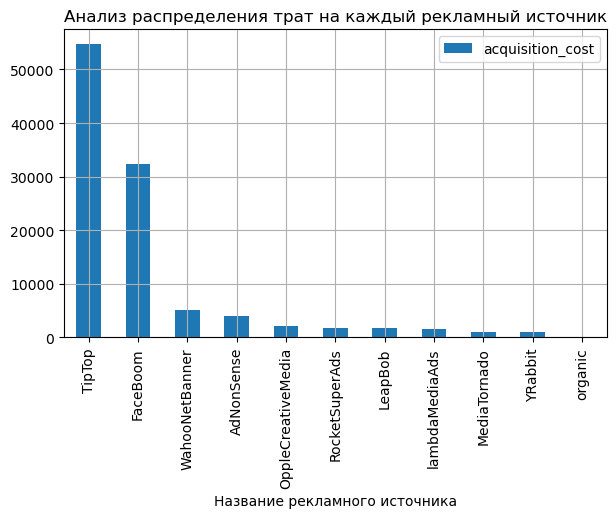

In [203]:
#постороим график для визуализации полученных данных
profiles.groupby('channel').agg({'acquisition_cost' : 'sum'}).sort_values(by=['acquisition_cost'],\
    ascending = False).plot.bar(grid=True, figsize=(7, 4))
plt.xlabel('Название рекламного источника')
plt.title('Анализ распределения трат на каждый рекламный источник')
plt.show()

#### Таким образом, мы выяснили, что наибольшие суммы для привлечения клиентов было потрачено на TipTop (54751.30), затем на FaceBoom (32445.60). 

### 4.3 Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. 
### Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.

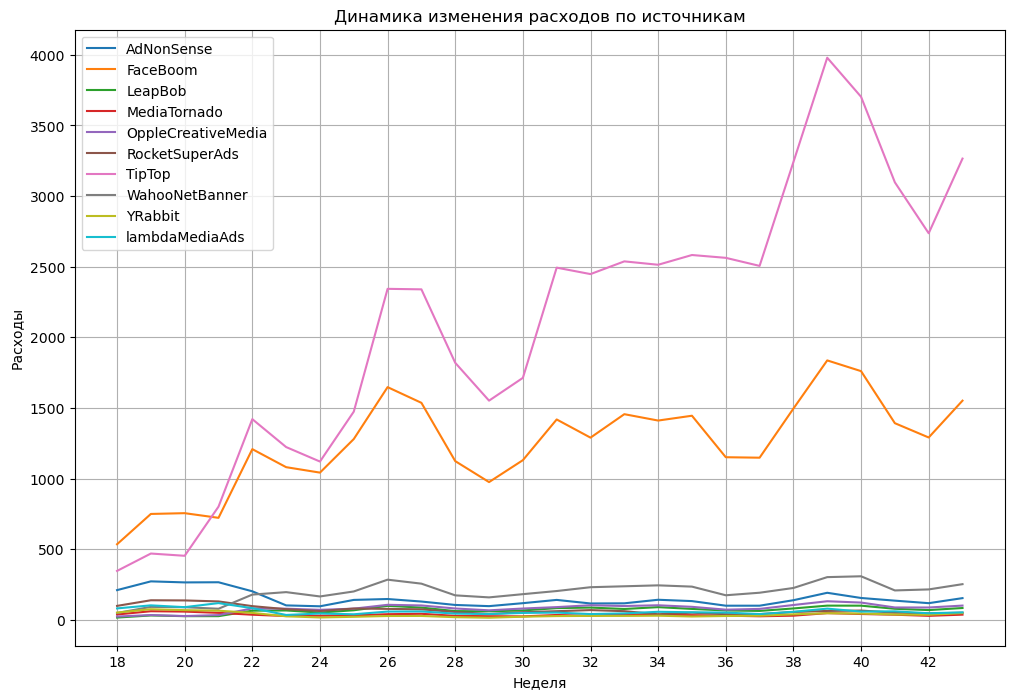

In [204]:
ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])
ad_costs['week'] = ad_costs['dt'].dt.isocalendar().week

grouped_data = ad_costs.groupby(['channel', 'week'])['costs'].sum().reset_index()

plt.figure(figsize=(12, 8))

for i, (channel, data_group) in enumerate(grouped_data.groupby('channel')):
    plt.plot(data_group['week'], data_group['costs'], 
             label=channel, 
             linestyle='-')

plt.title('Динамика изменения расходов по источникам')
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.xticks(range(min(ad_costs['week']), max(ad_costs['week'])+1, 2))
plt.legend()
plt.grid(True)
plt.show()

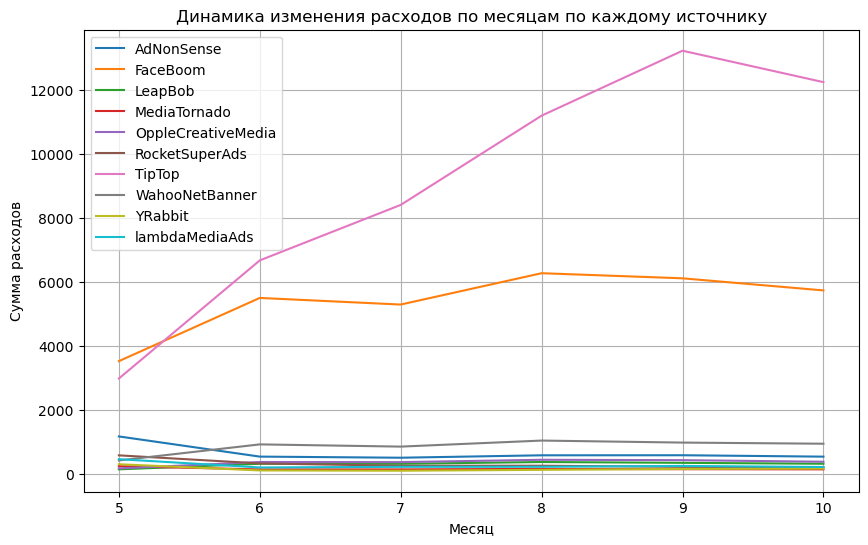

In [205]:
ad_costs['month'] = ad_costs['dt'].dt.month  # Создаем столбец с номером месяца

# Группируем данные по месяцам и источникам, считаем сумму расходов
monthly_costs = ad_costs.groupby(['channel','month'])['costs'].sum().reset_index()

# Строим график
plt.figure(figsize=(10, 6))
for channel in monthly_costs['channel'].unique():
    data = monthly_costs[monthly_costs['channel'] == channel]
    plt.plot(data['month'], data['costs'], label=channel)

plt.xlabel('Месяц')
plt.ylabel('Сумма расходов')
plt.title('Динамика изменения расходов по месяцам по каждому источнику')
plt.legend()
plt.grid(True)
plt.show()

#### Таким образом, мы можем сделать вывод, что в первоначальной точке расходы на TipTop и FaceBoom были в 2 раза выше, чем на все остальные каналы. Лидировал FaceBoom. Примерно серез 10 дней расходы на TipTop и FaceBoom сравнялись, а потом лидировал исключительно TipTop. На конец исследования расходы на рекламу в TipTop были более, чем в 2 раза выше по сравнению с FaceBoom и в 12 раз больше, чем на все остальные каналы.

#### Вполне возможно, что проблема неэффективности вложений в рекламу как раз и связана с избыточным финансированием этих двух каналов, от которых с течением времени, возможно, не так много стало приходить пользователей, а расходы по прежнему были распределены не равномерно.

### 4.4 Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.


In [206]:
# Находим уникальных пользователей каналов
users_by_channel = profiles.groupby('channel')['user_id'].nunique()

# Группируем затраты по каналам и подсчитываем общие затраты
total_costs_by_channel = ad_costs.groupby('channel')['costs'].sum()

# Рассчитываем CAC для каждого канала
cac_by_channel = total_costs_by_channel / users_by_channel

# Выводим среднюю стоимость привлечения одного пользователя (CAC) из каждого источника
cac_by_channel.sort_values(ascending=False)


channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
organic                    NaN
dtype: float64

#### Таким образом, получаем, что для привлечения одного нового пользователя  наибольшая сумма тратится в TipTop (2,8 денежных единиц), затем FaceBoom (1,1 д.е.) и AdNonSense (1 д.е.). Для organic данных нет, т.к. понятно, что это пользователи, пришедшие без расходов на рекламу.

## Минивыводы по маркетингу

- Общая сумма, потраченная на маркетинг составила 105497,3 денежных единиц.
- Наибольшие суммы для привлечения клиентов было потрачено на TipTop, затем на FaceBoom. 
- Уже в первоначальной точке расходы на TipTop и FaceBoom были в 2 раза выше, чем на все остальные каналы. Лидировал FaceBoom. Через неделю - расходы на TipTop и FaceBoom сравнялись, а потом лидировал исключительно TipTop. На конец исследования расходы на рекламу в TipTop были более, чем в 2 раза выше по сравнению с FaceBoom и в 12 раз больше, чем на все остальные каналы.
- Для привлечения одного нового пользователя наибольшая сумма тратится в TipTop (в среднем 2,8 денежных единиц), затем FaceBoom (1,1 д.е.) и AdNonSense (1 д.е.)

## Шаг 5 Окупаемость рекламы 
На календаре 1 ноября 2019 года (observation_date = 2019-11-01), горизонт момента (horizon_days) = 14 дней. 

### 5.1 Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [207]:
#исключим из датасета пользователей, пришедших не от рекламы
profiles = profiles.query('channel != "organic"')

Вызываем функцию get_ltv() для рассчета LTV

In [208]:
result_raw,  result_grouped,  result_in_time,  roi_grouped,  roi_in_time = get_ltv(
    profiles,
    orders,
    observation_date=datetime(2019, 11, 1).date(),
    horizon_days=14,
    dimensions=[],
    ignore_horizon=False,
)

Построим графики для LTV, ROI, CAC

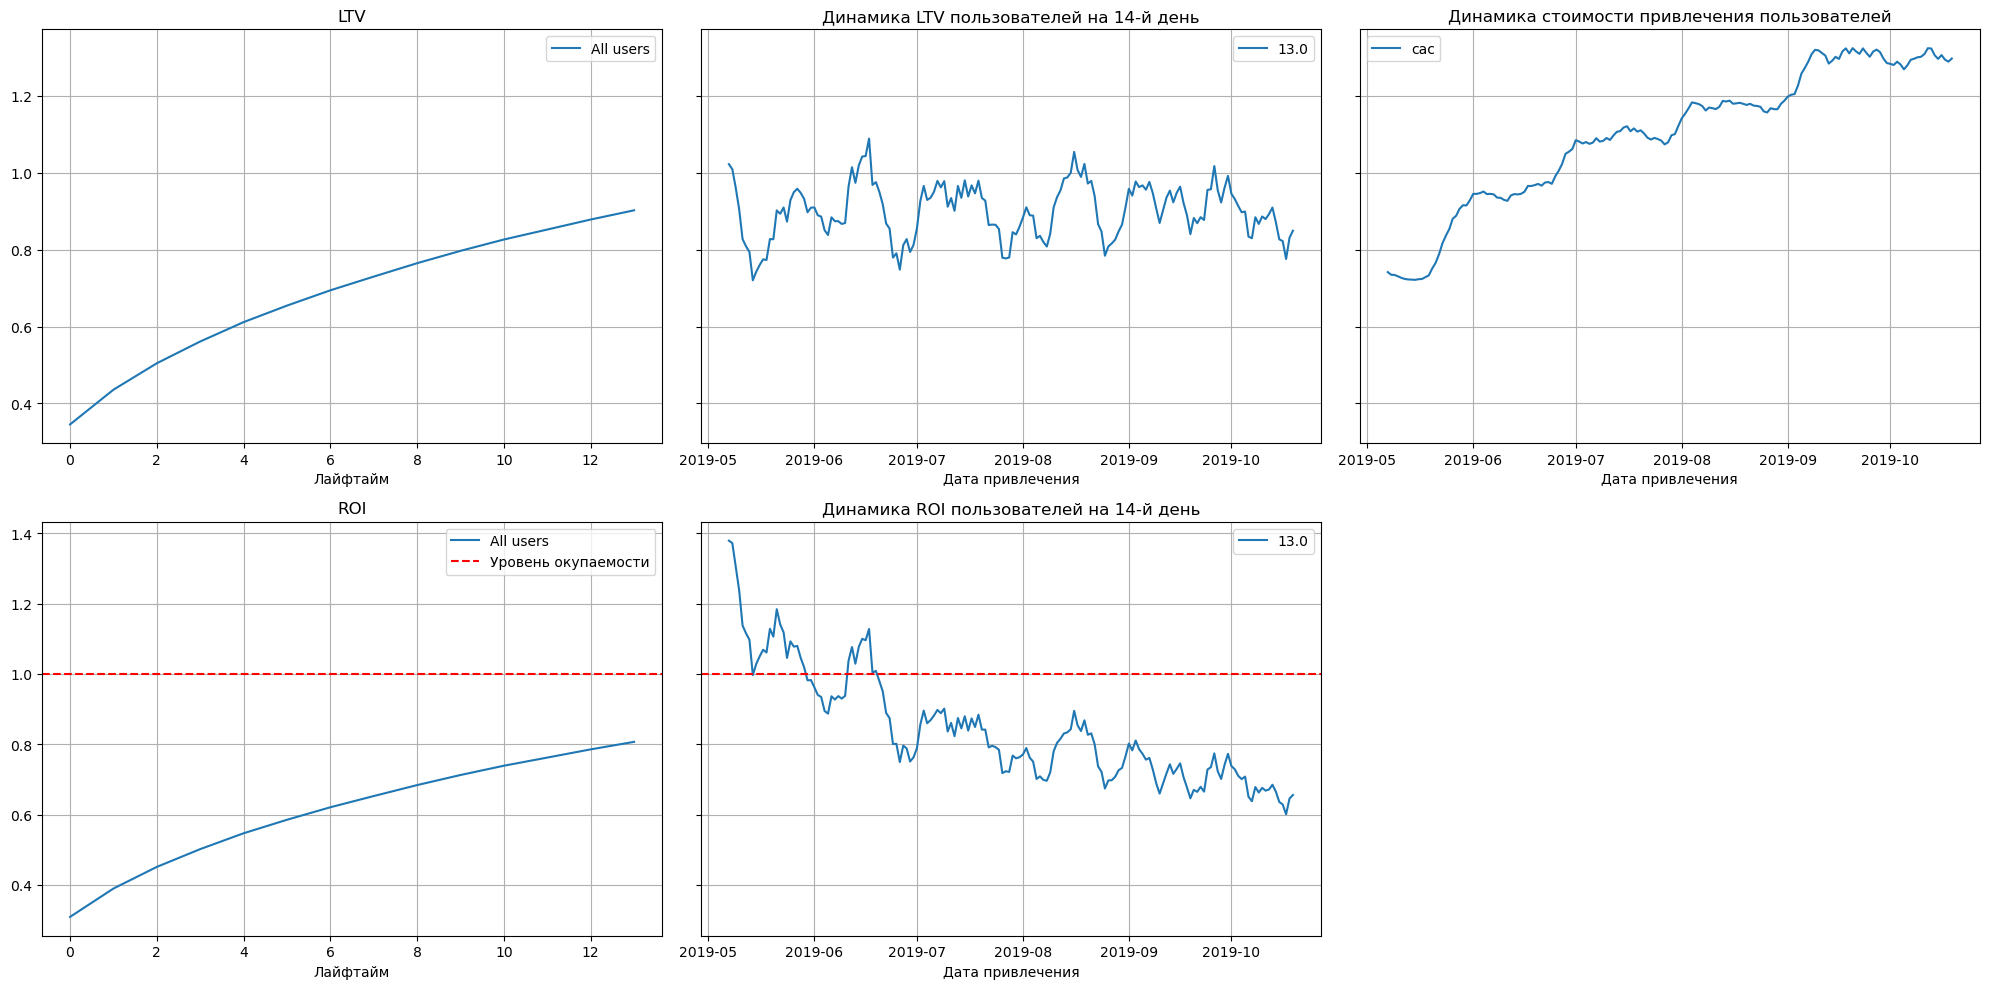

In [209]:
plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, 14, window=7)

#### LTV и ROI  растут - значит ошибок при построении нет. CAC увеличивается с течением времени, т.е. расходы на рекламу продолжаются.  Динамика LTV имеет синусоиду на графике, на конец изучаемого периода средняя стоимость клиента равна чуть больше 0.8 д.е., весь график уклажывается в синусоиду в пределах от 0,8 до 1,1 д.е. Это хорошо и стабильно. 
#### ROI вырос за 14 дней с 0,3 до 0,8 д.е., но этого не достаточно, т.к. за 2 недели он не вышел на уровень окупаемости. В динамике это выглядит как падение с 1,4 д.е. в самом начале до 0,65 через 2 недели, т.е. в 2 раза.

## 5.2 Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.

In [210]:
observation_date=datetime(2019, 11, 1).date()
horizon_days = 14

Вызываем функцию get_conversion() для расчета конверсии

In [211]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)

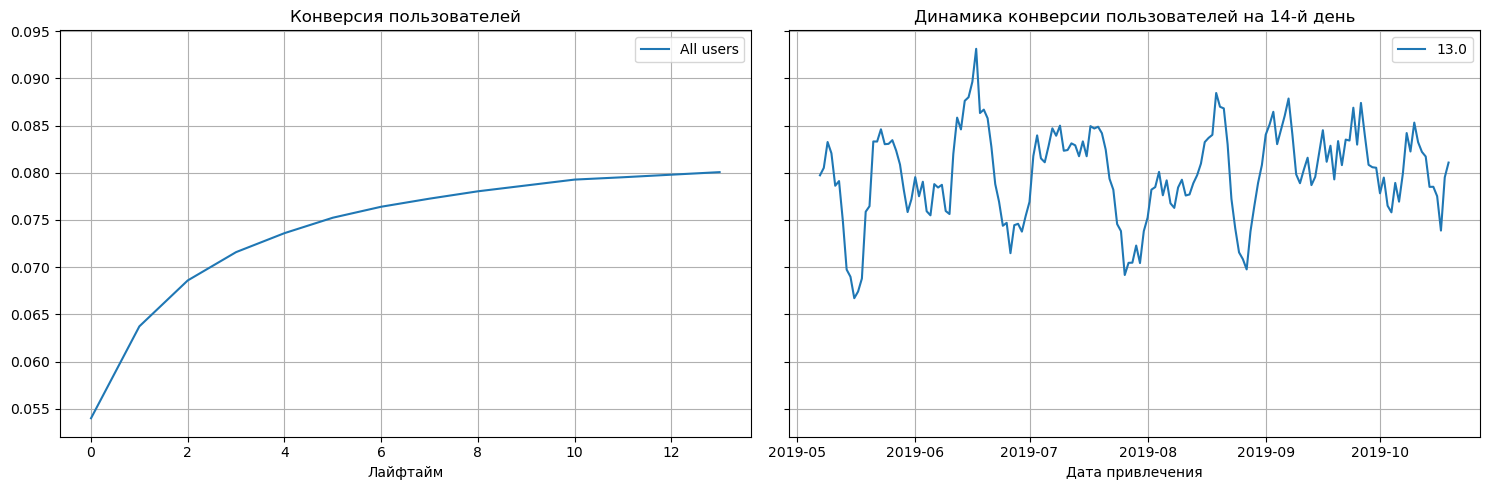

In [212]:
#применим функцию plot_conversion для построения графика конверсии
plot_conversion(conversion, conversion_history, horizon_days, window=7)

#### По графику мы видим, что сначала идет экспоненциальный рост примерно до 3 лайфтайма, а потом происходит плавный выход на плато ( с 6 по 13 лайфтайм прирост конверсии менее, чем на 5%). Динамика конверсии укладывается в промежуток от 70 до 90%. На мой взгляд, с конверсией все неплохо.

Можно посмотреть на конверсию по каналам входа, т.к. именно с расходами на рекламу у нас проблема.

In [213]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'],
    ignore_horizon=False,)

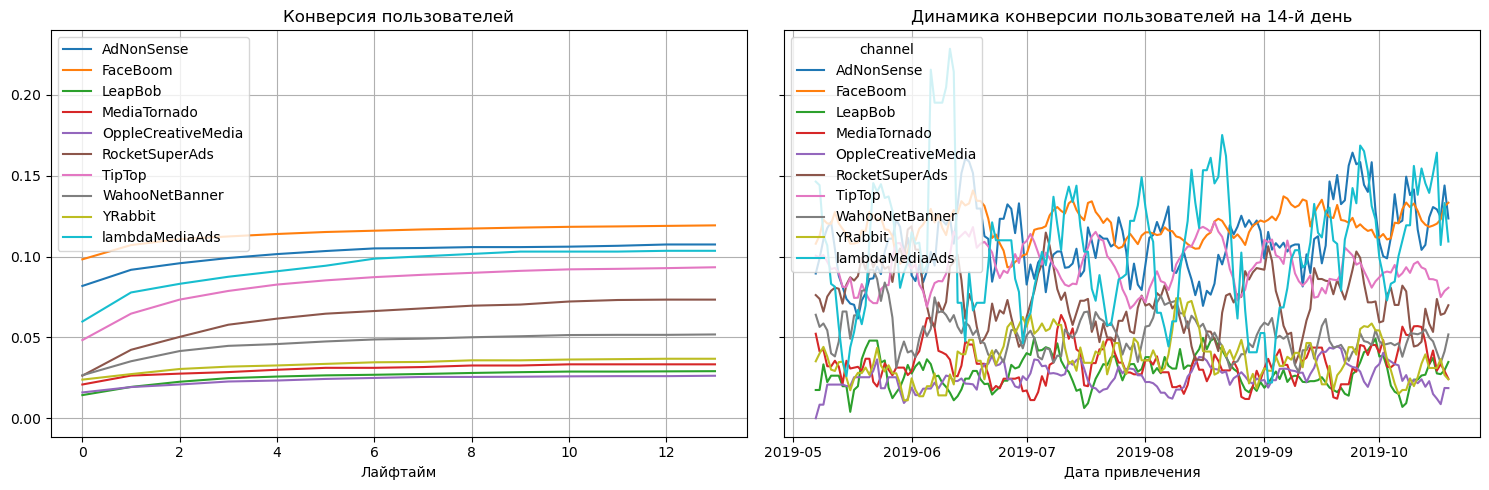

In [214]:
plot_conversion(conversion, conversion_history, horizon_days, window=7)

**Интересно, что самая высокая конверсия у канала FaceBoom, затем AdNonSense и LambdaMediaAds, а TipTop оказался лишь на 4 месте.** 

**Посмотрим теперь удержание пользователей в динамике и по каналам.**

In [215]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
)

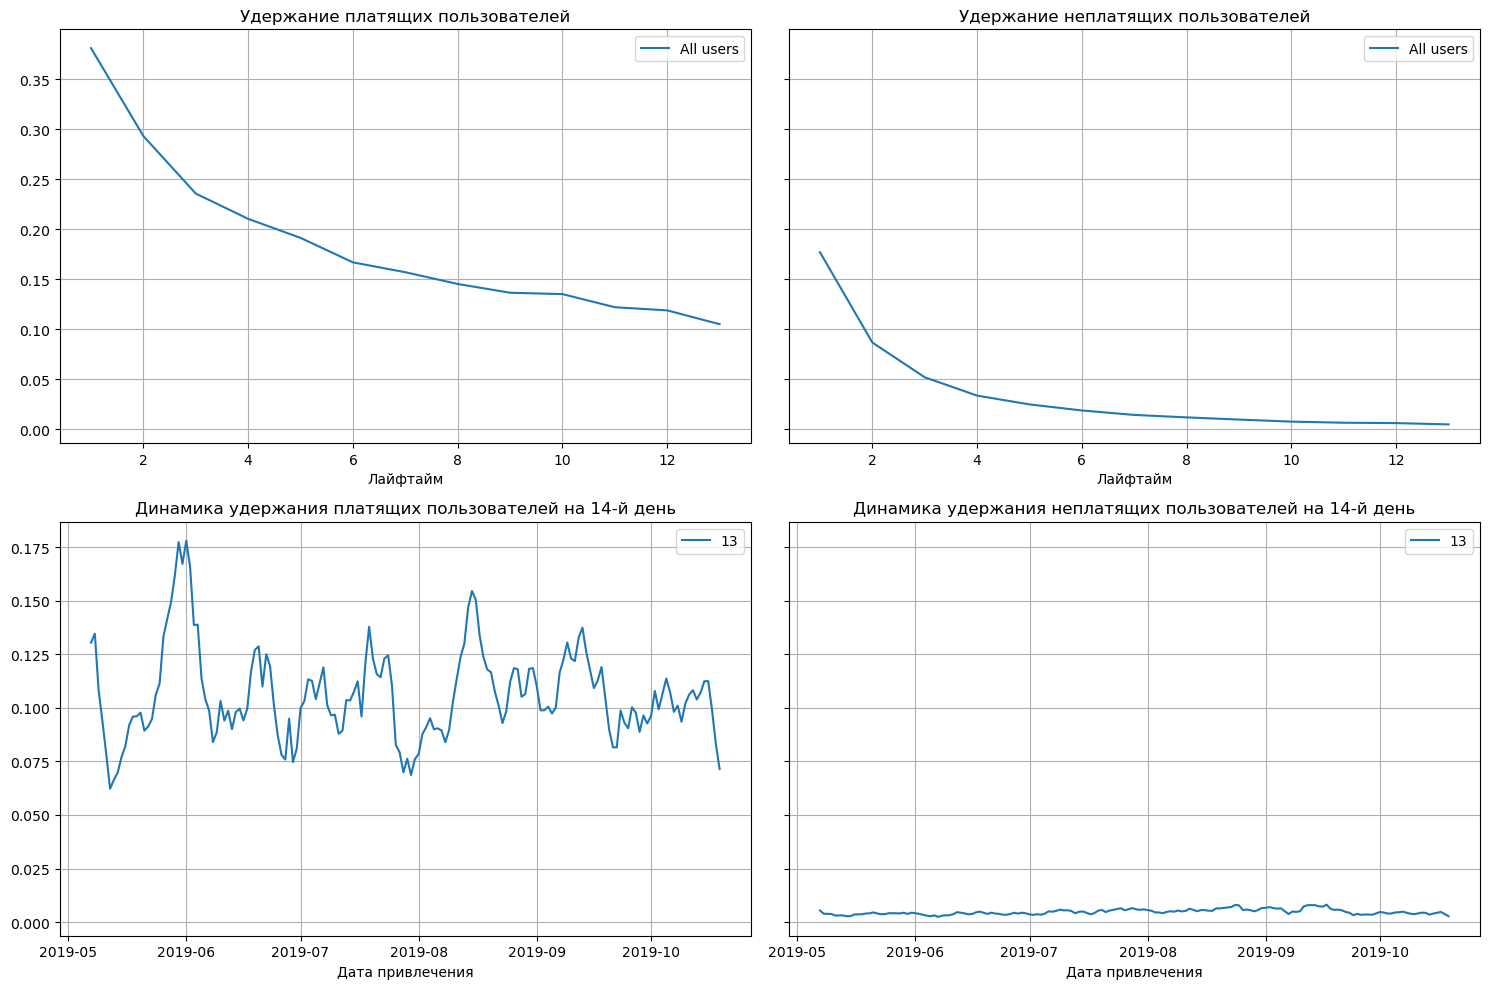

In [216]:
plot_retention(result_grouped, result_in_time, horizon_days, window=7)

**По графикам мы можем сделать вывод, что удержание платящих пользователей проходит более плавно. За 14 лайфтаймов произошло снижение примерно с 38% до 10%, за  это время неплатящие снизились с 18% до 1%. По разнице кажется, что неплатящие снизились на 17% по сравнению с 28 у платящих. Но их уровень опустился практически до 0, что показывает минимальную вероятность совершения новой покупки в будущем.**

**Динамика удержания стандарная синусоида, удержание неплатящих обычно довольно низкое, что отображено на графике как прямая линия близкая к 0.**

Расчитаем удержание с разбивкой по странам.

In [217]:
#применим функцию get_retention для расчета удержания
result_raw, result_grouped, result_in_time = get_retention(profiles,sessions,observation_date,horizon_days,\
                                                           dimensions=['region'],ignore_horizon=False)

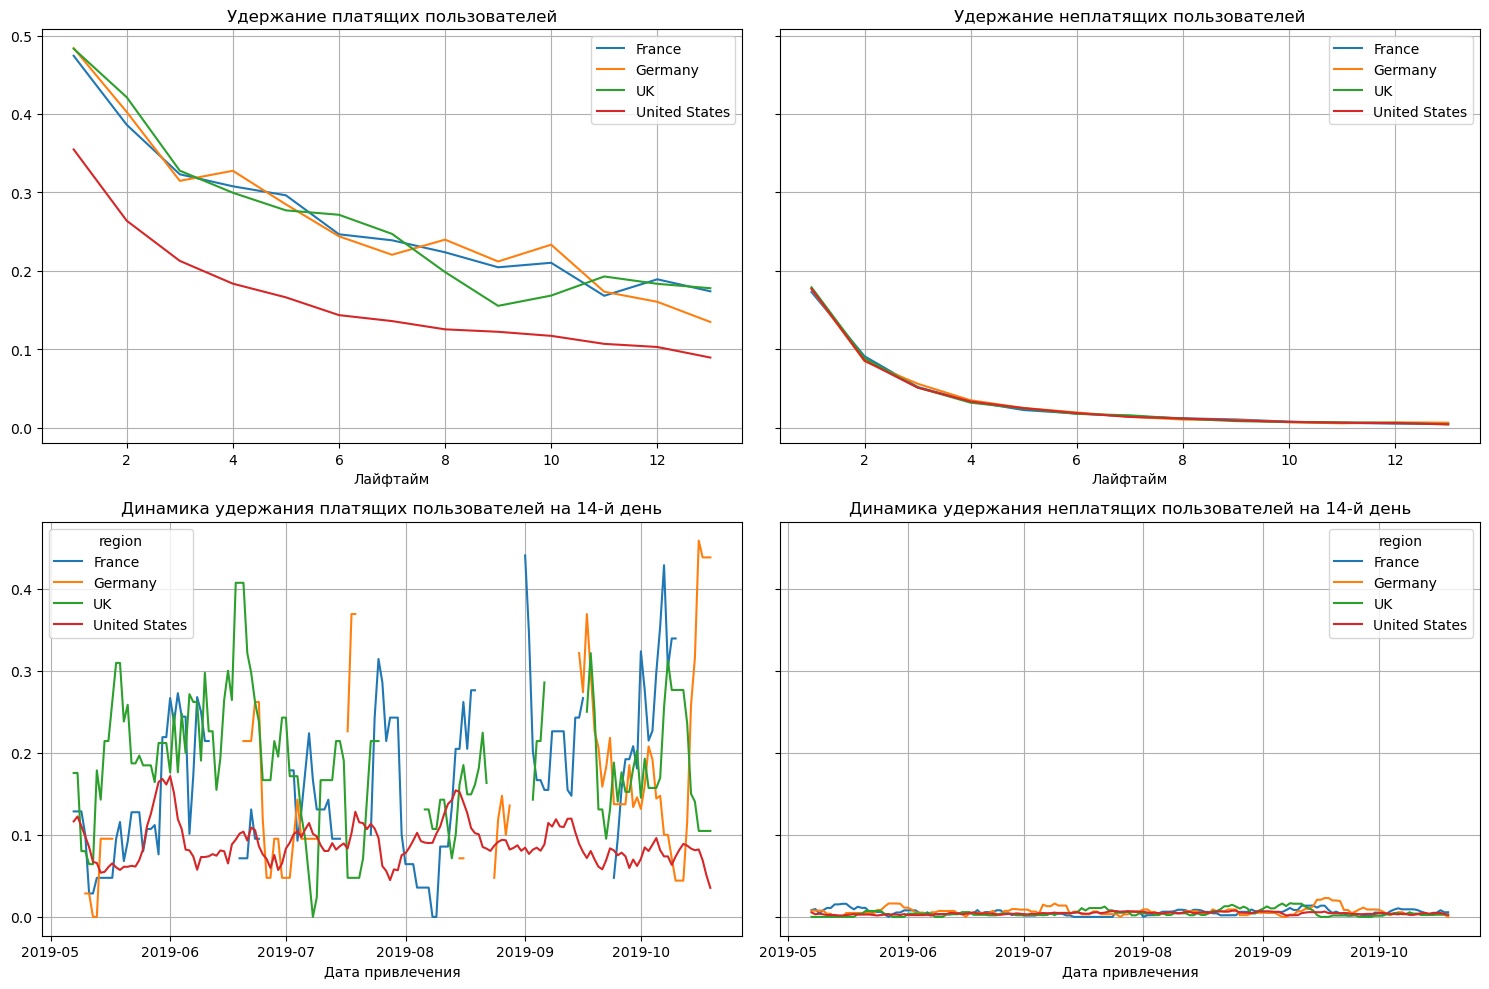

In [218]:
#применим функцию plot_retention для построения графика удержания
plot_retention(result_grouped, result_in_time, horizon_days, window=7)

#### Вывод: удержание по США ниже, чем по другим странам. Остальные страны совсем незначительно отличаются друго от друга.

Расчитаем коэффициента удержания с разбивкой по каналам привлечения.

In [219]:
#применим функцию get_retention для расчета удержания
result_raw, result_grouped, result_in_time = get_retention(profiles,sessions,observation_date,horizon_days,\
                                                           dimensions=['channel'],ignore_horizon=False)

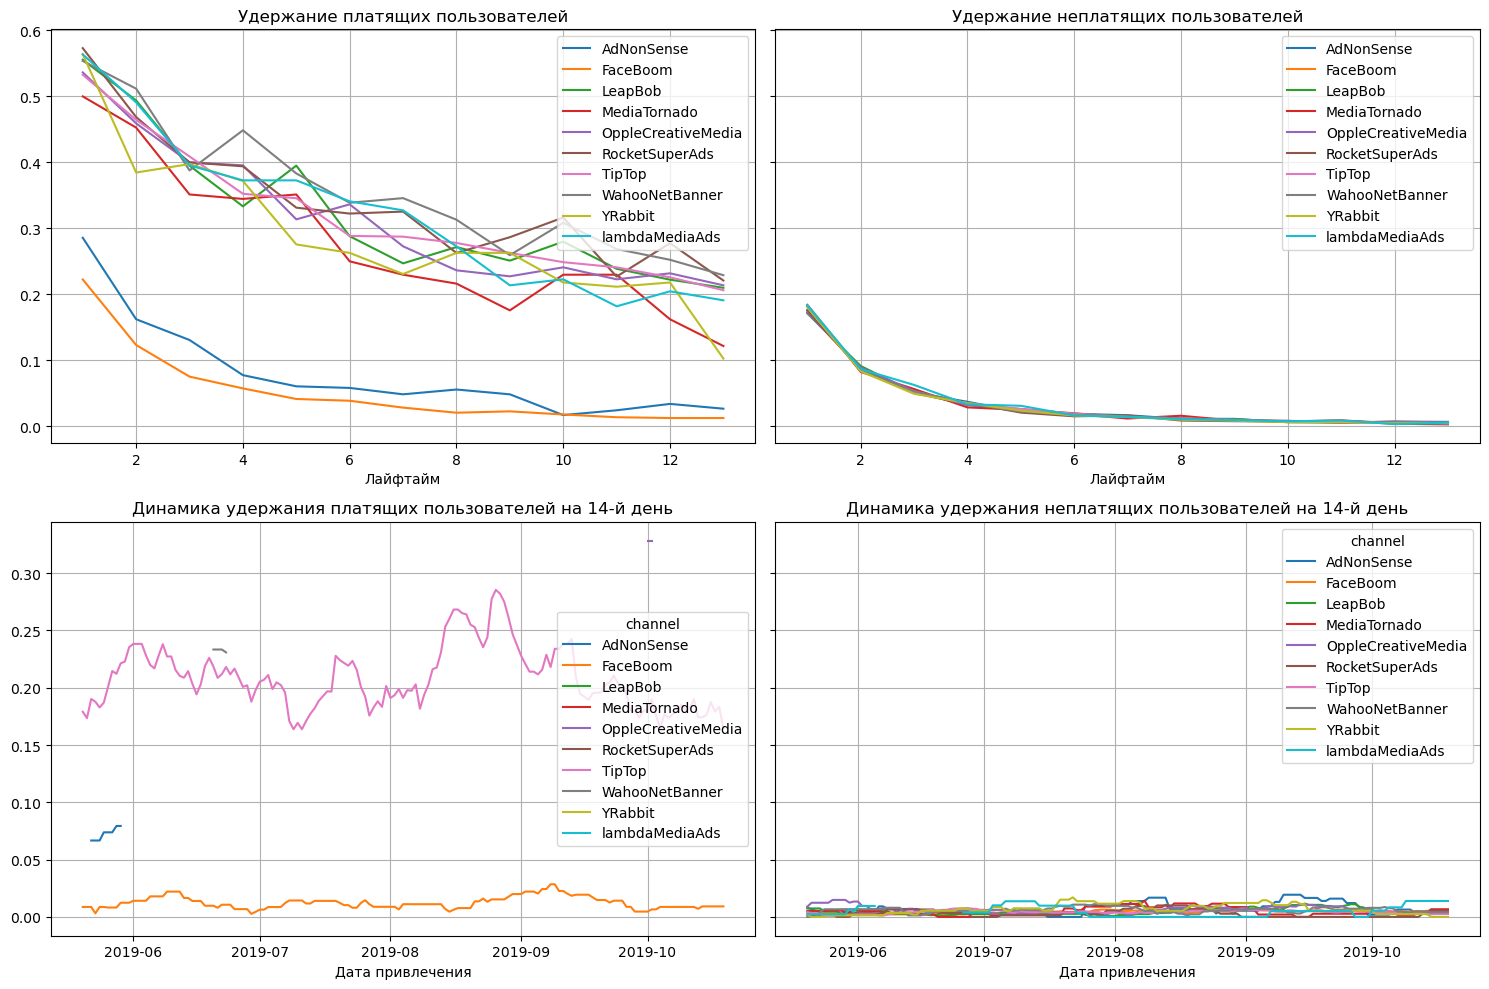

In [220]:
#применим функцию plot_retention для построения графика удержания
plot_retention(result_grouped, result_in_time, horizon_days, window=20)

**Выявляются проблемы с удержанием пользователей, которые пришли из FaceBoom и AdNonSense. Следует отметить, что динамика удержания неплатящих пользователей более сглажена, чем платящих. Вероятно, это м.б. связано с работой рекламного отдела для разных устройств.**  

### 5.3 Сделаем рассчеты с учетом устройств, которые исполльзоватли для входа.

Проанализируйте окупаемость рекламы с разбивкой по устройствам ('device'). Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [221]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'],ignore_horizon=False,
)

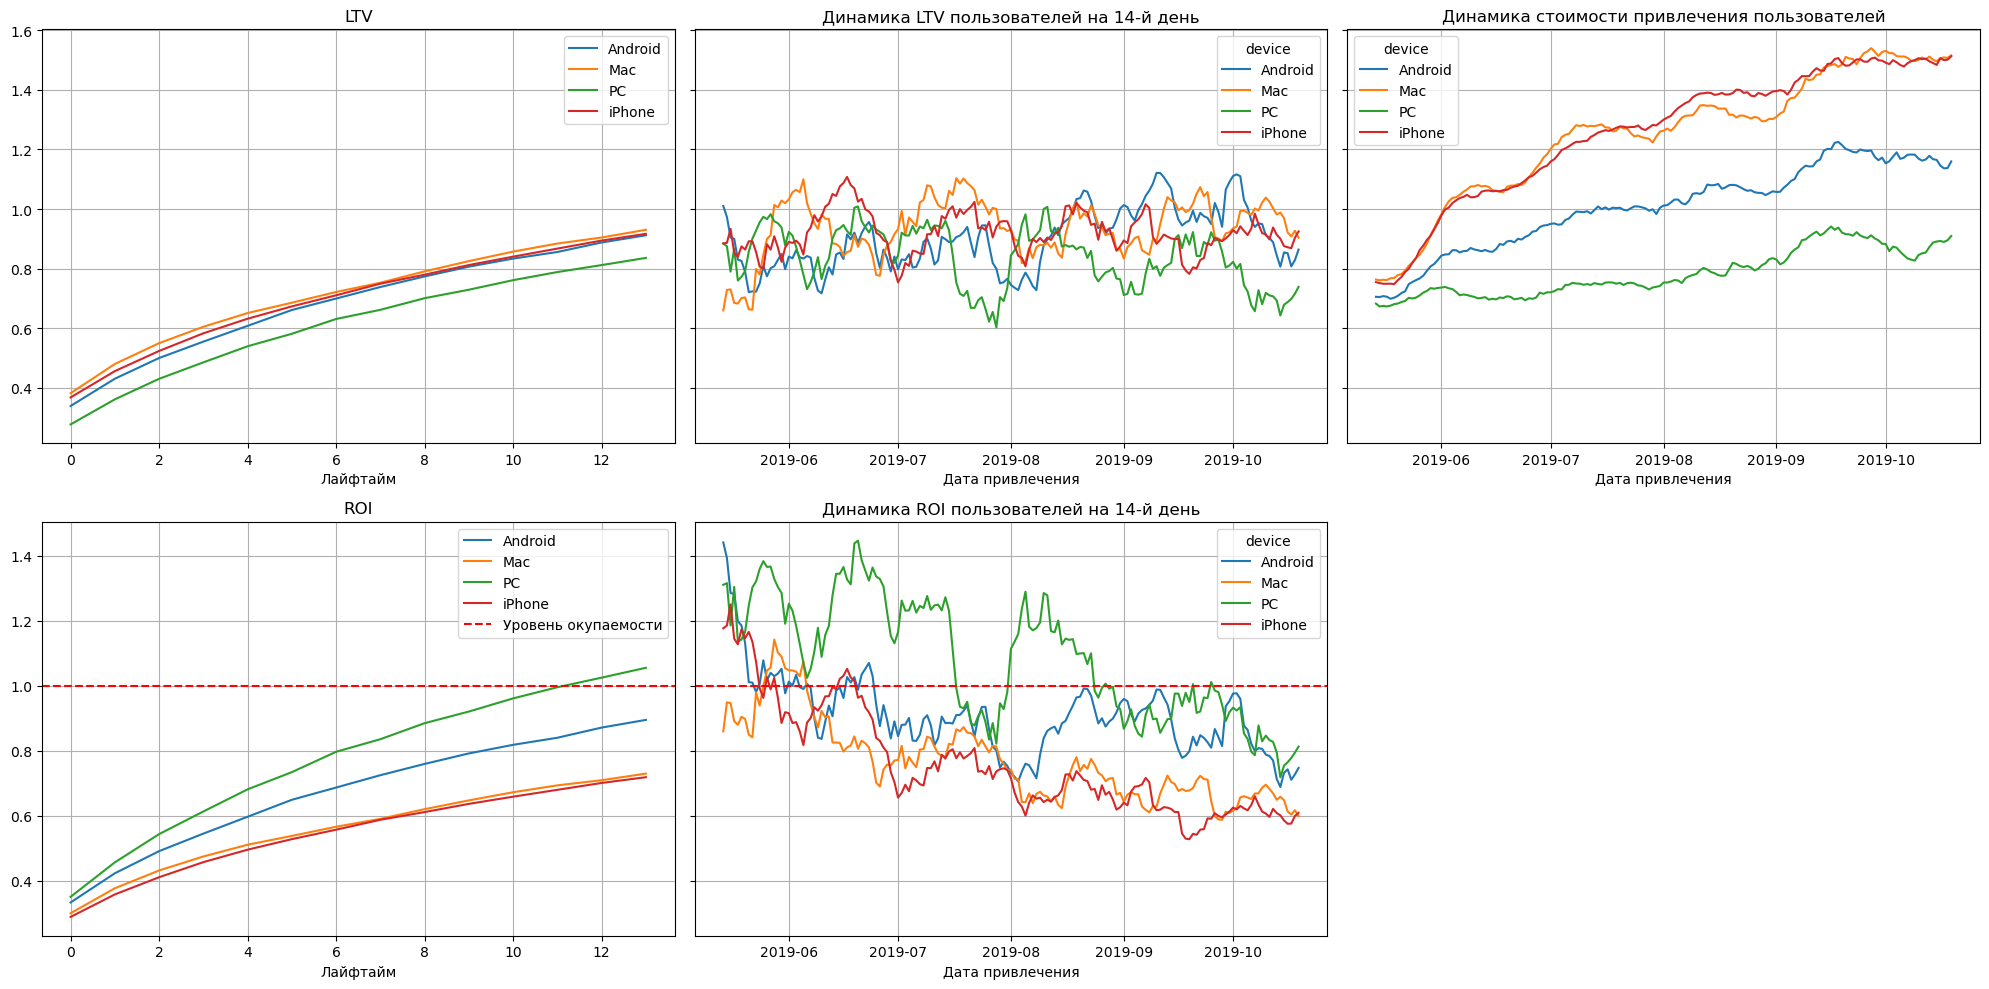

In [222]:
#построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

После разбивки по каналам, мы можем сказать что лидирующего канала по LTV нет, но три устройства (Mac, Android и iPhone) примерно одинаково обеспечивают LTV пользоватлей. РС стартовал с меньшей позиции, чем остальные, однако показывает точно такой же параллельный рост LTV. В динамике LTV мы можем увидеть два пика падения именно для РС в середине исследуемого периода и ближе к концу, однако вцелом, лидера по динамике определить достаточно трудно. 
САС, как и должно быть, показывает рост, однако Мас и iPhone идут вместе и лидируют, а вот Android и РС различаются от них к концу периода примерно на 1 и 2 д.е. соответственно. 

Тем интереснее проверить ROI, т.е. окупаемость по каналам. Тут мы видим, что к концу периода анализа только РС преодолел уровень окупаемости (еще на 11 лайфтайме). Судя по плавному росту кривых Android и тем более Мас и iPhone, они не достигнут в ближайшее время уровня окупаемости. 

Судя по графику ROI в динамике, выход на окупаемость для РС была достигнута высокими значениями в первых 2\3 периода исследования, т.к. в последней трети мы видим спад уже ниже уровня окупаемости. Остальные три типа устройств практически все время находятся ниже уровня окупаемости, поэтому мы не можем предположить их выход на окупаемость в ближайшее время. 


## 5.4 Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

Проделаем те же операции, что и в п.5.3, но уже для разбивки по странам 'region'.

In [223]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'],ignore_horizon=False,
)

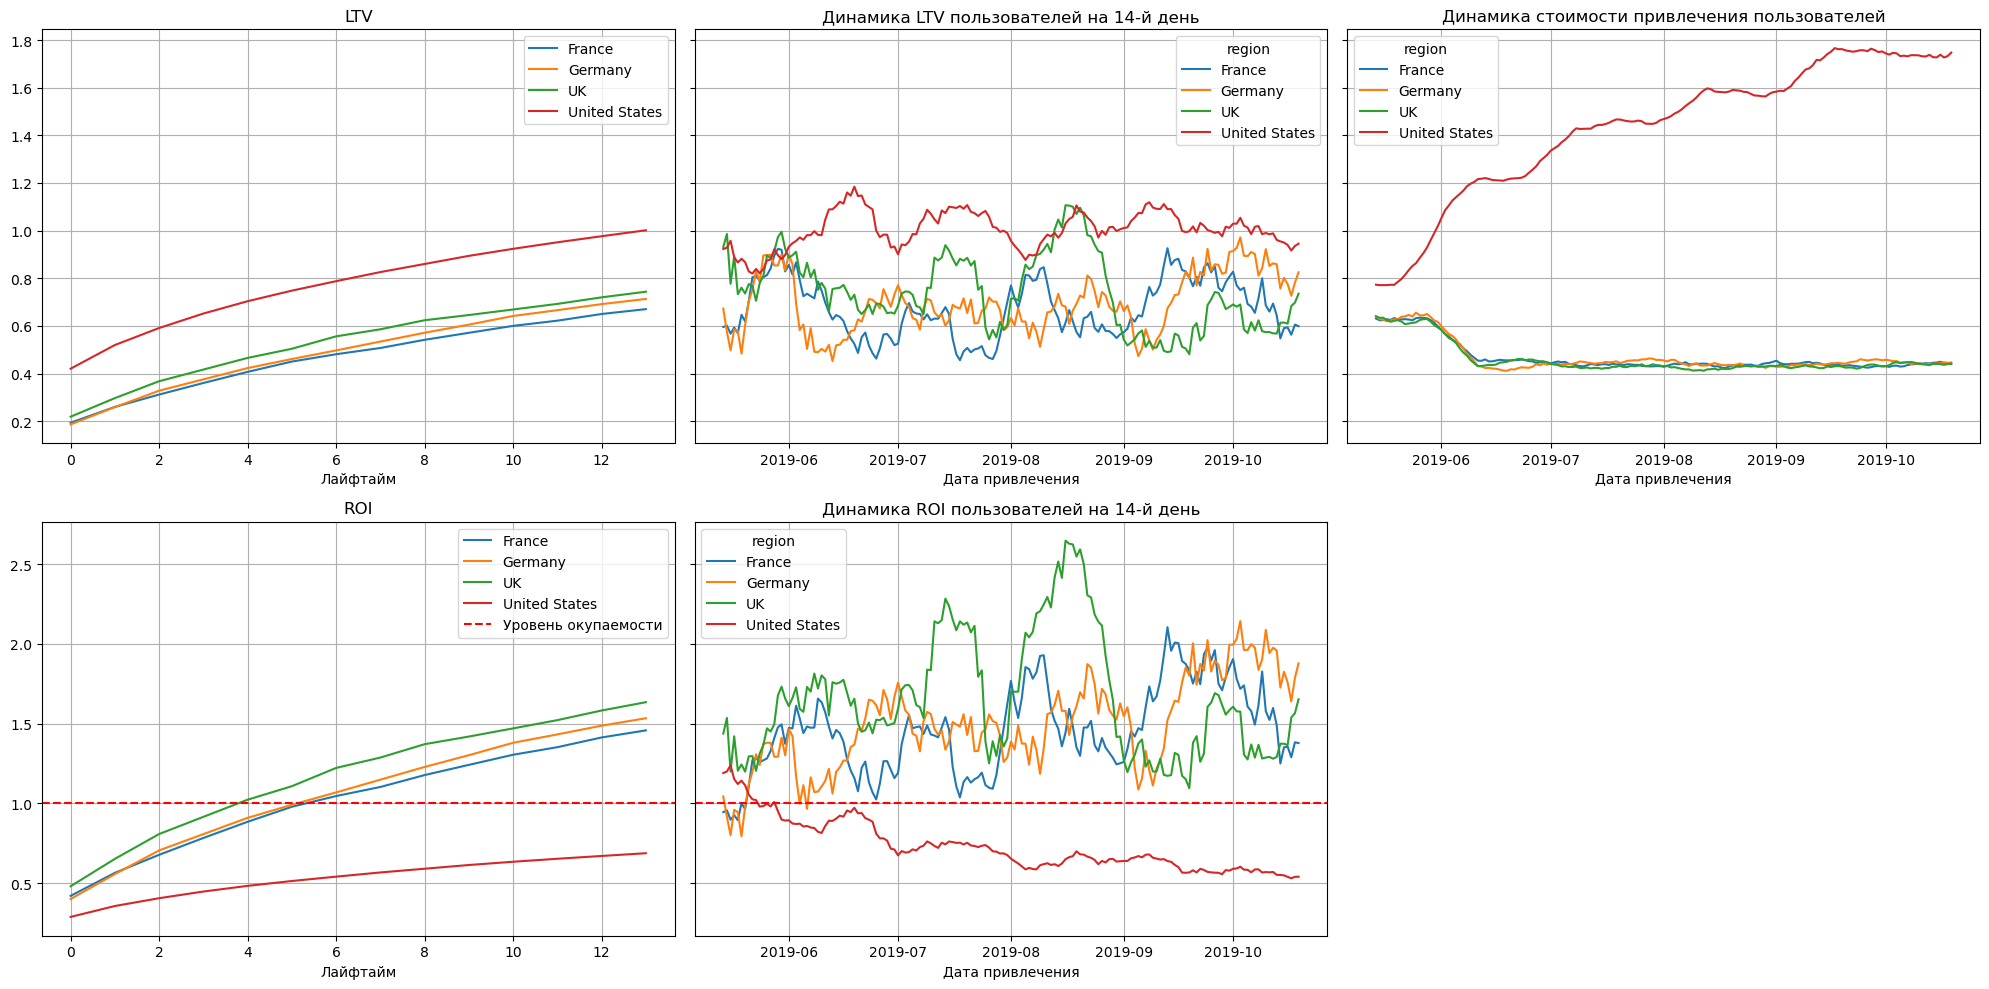

In [224]:
#построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

С точки зрения распределения по странам, тут очевидный лидер пользователи США. У них самый высокий LTV и в динамике тоже. Однако САС для США также очень высокий и растет не пропорционально остальным странам, а просто с огромным рразрывом. Видимо, маркетологи сосредоточились именно на этой платежеспособной стране с большим населением и вложились, вероятно еще и в один канал (FB, как известно, очень популярный в США). Судя по форме кривой ROI для США, в ближайшее время инвестиции туда не окупятся. Думаю, необходимо снижать такие огромные расходы на рекламу в США. Поскольку все остальные страны менее, чем к середине уже вышли на окупаемость инвестиций. 

ROI в динамике для США также покасывает продолжающийся спад, в то время как в других странах ROI лежит выше уровня окупаемости практически с начала исследования.

## 5.5 Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [225]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'],ignore_horizon=False,
)

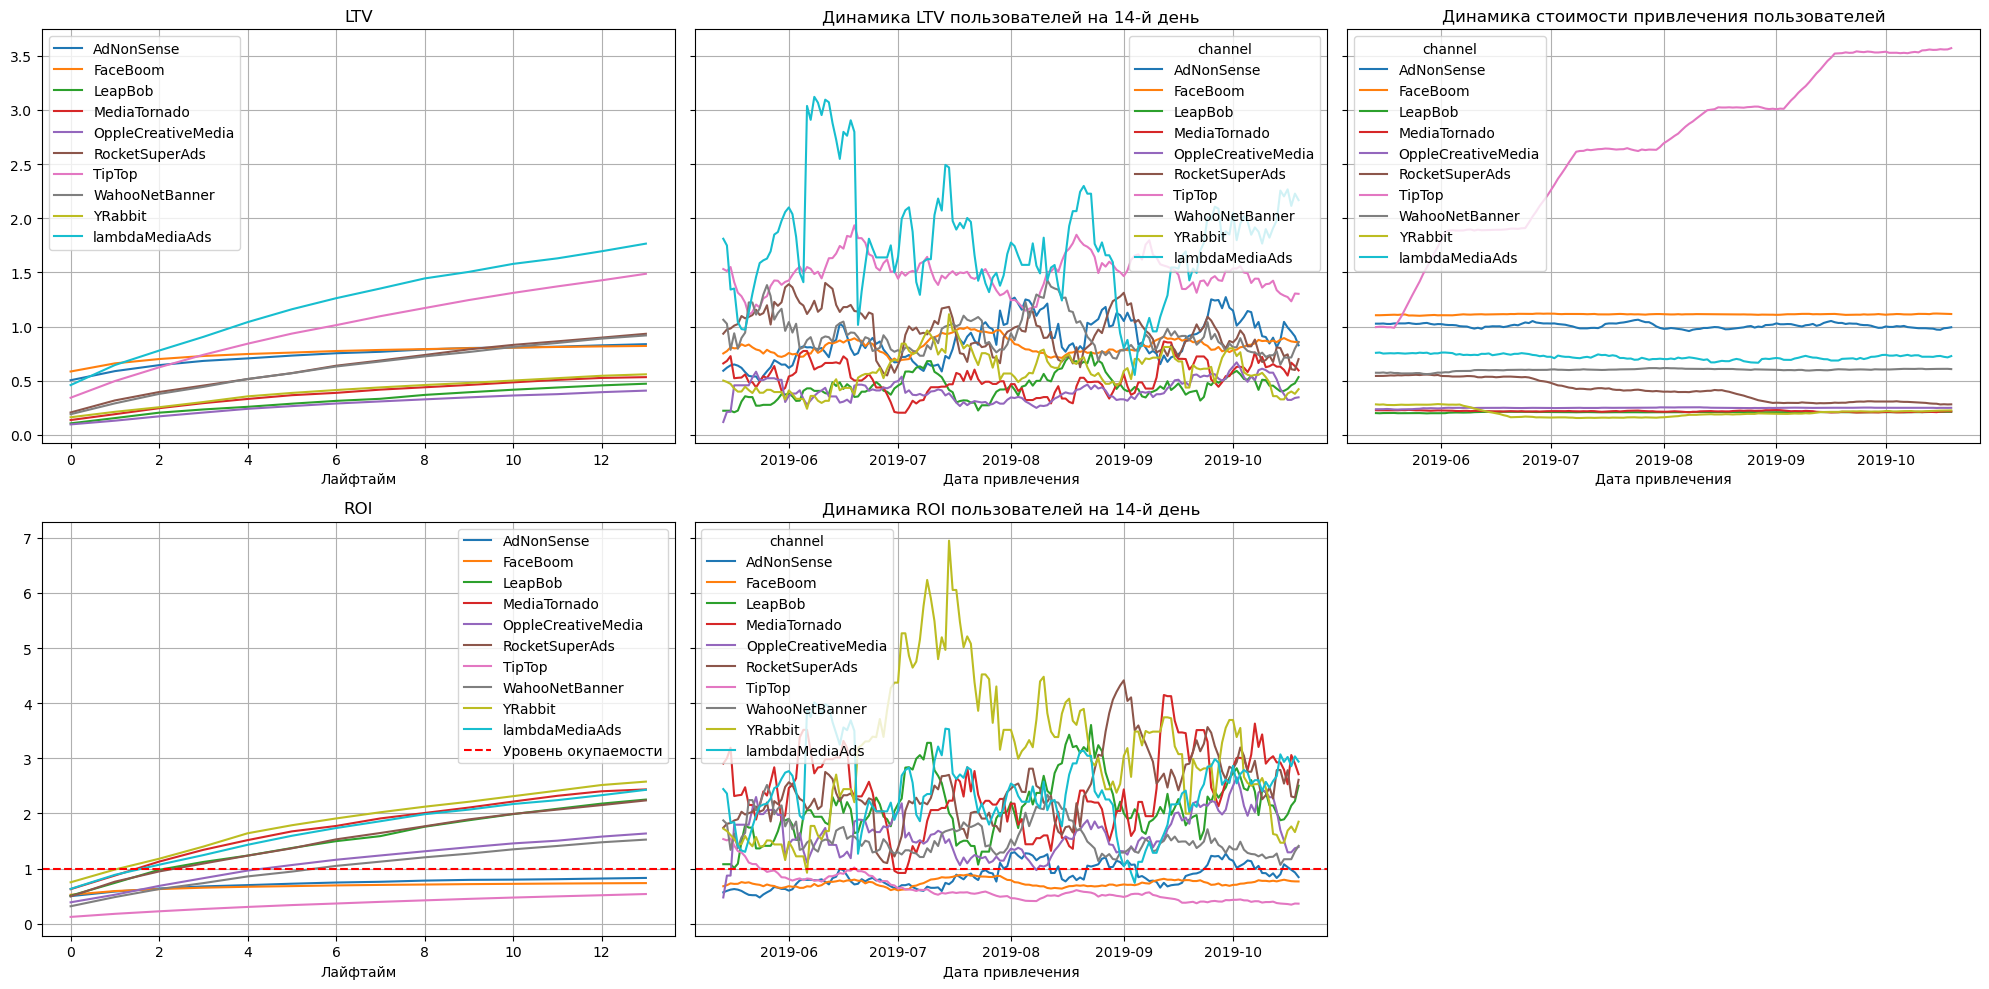

In [226]:
#построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам мы видим, что лидер LTV и LTV в динамике это LambdaMediaAds. Параллельно с TipTop они уверенно растут весь период анализа (LTV вырос в более, чем 3 раза). 

САС стремительно растет (похоже как рост в США) для TipTop, т.е. деньги активно вкладываются в этот канал на фоне стабильного САС для остальных каналов.

ROI смогли преодолеть практически все каналы, кроме тех, в которые было вложено больше всего денег: TipTop, FaceBoom, AdNonSense. Лидер YRabbit окупился в динамике сразу. 

## Минивыводы по окупаемости рекламы.

- LTV и ROI  растут - значит ошибок при построении нет. CAC увеличивается с течением времени, т.е. расходы на рекламу продолжаются.  Динамика LTV имеет синусоиду на графике, на конец изучаемого периода средняя стоимость клиента равна чуть больше 0.8 д.е., весь график уклажывается в синусоиду в пределах от 0,8 до 1,1 д.е. Это хорошо и стабильно. 
- ROI вырос за 14 дней с 0,3 до 0,8 д.е., но этого не достаточно, т.к. за 2 недели он не вышел на уровень окупаемости. В динамике это выглядит как падение с 1,4 д.е. в самом начале до 0,65 через 2 недели, т.е. в 2 раза.
- Динамика конверсии укладывается в промежуток от 70 до 90%. Cамая высокая конверсия у канала FaceBoom, затем AdNonSense и LambdaMediaAds. TipTop оказался лишь на 4 месте.
- Лидирующего канала по LTV нет, но три устройства (Mac, Android и iPhone) примерно одинаково обеспечивают LTV пользоватлей. САС, как и должно быть, показывает рост, однако Мас и iPhone идут вместе и лидируют, а вот Android и РС различаются от них к концу периода примерно на 1 и 2 д.е. соответственно. 
- При анализе ROI мы видим, что к концу периода анализа только РС преодолел уровень окупаемости (еще на 11 лайфтайме). Судя по плавному росту кривых Android и тем более Мас и iPhone, они не достигнут в ближайшее время уровня окупаемости. 
- С точки зрения распределения по странам, тут очевидный лидер пользователи США. Однако САС для США также очень высокий и растет не пропорционально остальным странам, а просто с огромным рразрывом. Судя по форме кривой ROI для США, в ближайшее время инвестиции туда не окупятся. 
- лидер LTV и LTV в динамике это LambdaMediaAds. Параллельно с TipTop они уверенно растут весь период анализа (LTV вырос в более, чем 3 раза). 
 - САС стремительно растет для TipTop, т.е. деньги активно вкладываются в этот канал на фоне стабильного САС для остальных каналов.
- ROI смогли преодолеть практически все каналы, кроме тех, в которые было вложено больше всего денег: TipTop, FaceBoom, AdNonSense. Лидер YRabbit окупился в динамике сразу. 

## ответы на главные вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом?

- **Нет, не окупается, т.к. ROI вырос за 14 дней с 0,3 до 0,8 д.е., но этого не достаточно, т.к. за 2 недели, которые были условием руководства,  он не вышел на уровень окупаемости. В динамике это выглядит как падение с 1,4 д.е. в самом начале до 0,65 через 2 недели, т.е. в 2 раза.**

- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

- **лидером среди устройств выделяется РС, который при самых низких вложениях в рекламу единственный показал выход на окупаемость. При том, что Мас и iPhone показывают окупаемость ниже при существенно больших вливаниях в рекламу.**
- **из стран по вложениям в рекламу лидер США. Однако несмотря на существенно большее количество пользователей, ROI в США самый низкий, поскольку мы видим оргомные вливания денег на рекламу в эту страну, которая не приводит к такому же высокому приросту платящих и постоянно покупающих пользователей.**
- **лидером из каналов можно назвать неприметный LambdaMediaAds, который окупился мгновенно. Хотя, если на него было потрачено мало денег и через него пришли также немного пользователей, то, конечно, вложения окупились, но прибыли компании не много. TipTop, FaceBoom, AdNonSense - лидирующие по вложениям, пока не окупились**.

- Чем могут быть вызваны проблемы окупаемости?

- **проблемы м.б. связаны с чрезмерным вложением рекламных денег в США и каналы TipTop, FaceBoom. Оптимизация расходов пропорционально, или выделение новых каналов, например, LambdaMediaAds или AdNonSense с хорошим потенциалом для роста**

# Выводы по проекту

1. В процессе исследования мы анализировали три датасета с данными о посещениях, заказах и рекламных расходах развлекательного приложения Procrastinate Pro+.
2. ДФ visits содержит 309901 строку и 6 столбцов, 
 - ДФ orders содержит 40212 строк и 3 столбца, 
 - ДФ costs содержит 1800 строки и 3 столбца. Пропуски и дубликаты не обнаружены.
3. Задали функции для расчёта и анализа LTV, ROI, удержания и конверсии: get_profiles(), get_retention(), get_conversion(), get_ltv_roi() и для создания графиков.
4. Были составлены профили пользователей. Получено 150008 уникальных профилей пользователей. Определен период представленных данные пользователей: с 1 мая 2019 года по 27 октября 2019 года. 
5. Было показано, что ользователи пришли из 4 стран: Великобритания, Германия, Франция, США. США - лидер по платящим клиентам. Пользователи используют 4 типа устройств: Android, Mac, PC, iPhone. Платящие пользователи предпочитают iPhone. Пользователи используют 11 типов каналов входа. По количеству пользователей лидирует organic(56'439), т.е. люди, пришедшие сами, а не по рекламе. Среди каналов лидер - FaceBoom(29'144), затем TipTop (19'561). Каналом-лидером по входу платящих пользователей можно назвать FaceBoom (3557 пользователей), затем TipTop(1878) и organic (1160). 
6. Общая сумма, потраченная на маркетинг составила 105497,3 денежных единиц. Наибольшие суммы для привлечения клиентов было потрачено на TipTop, затем на FaceBoom. На конец исследования расходы на рекламу в TipTop были более, чем в 2 раза выше по сравнению с FaceBoom и в 12 раз больше, чем на все остальные каналы.
7. Для привлечения одного нового пользователя наибольшая сумма тратится в TipTop (в среднем 2,8 денежных единиц), затем FaceBoom (1,1 д.е.) и AdNonSense (1 д.е.). 
8. LTV и ROI  растут - значит ошибок при анализе данных нет. CAC увеличивается с течением времени, т.е. расходы на рекламу продолжаются.  Динамика LTV имеет синусоиду на графике, на конец изучаемого периода средняя стоимость клиента равна чуть больше 0.8 д.е., весь график уклажывается в синусоиду в пределах от 0,8 до 1,1 д.е.
- удержание по США ниже, чем по другим странам. Остальные страны совсем незначительно отличаются друго от друга.
- Выявляются проблемы с удержанием пользователей, которые пришли из FaceBoom и AdNonSense. Следует отметить, что динамика удержания неплатящих пользователей более сглажена, чем платящих. Вероятно, это м.б. связано с работой рекламного отдела для разных устройств.

9. ROI вырос за 14 дней с 0,3 до 0,8 д.е., но этого не достаточно, т.к. за 2 недели он не вышел на уровень окупаемости. Cамая высокая конверсия у канала FaceBoom, затем AdNonSense и LambdaMediaAds. В то время как на TipTop оказался лишь на 4 месте.
10. С точки зрения распределения по странам, тут очевидный лидер пользователи США. Однако САС для США также очень высокий и растет не пропорционально остальным странам, а просто с огромным рразрывом. Судя по форме кривой ROI для США, в ближайшее время инвестиции туда не окупятся. 
11. ROI смогли преодолеть практически все каналы, кроме тех, в которые было вложено больше всего денег: TipTop, FaceBoom, AdNonSense. Лидер YRabbit окупился в динамике сразу. 

### рекомендации для отдела маркетинга

- не делать ставку только на один-два самых известных канала для входа, т.к. расходы на рекламу там могут сильно превышать приход пользователей. 
- проработать предпочтения для самой большой когорты пользователей - платящие пользователи США, чтобы как можно большее их количество продолжали покупать контент, а не уходили после 1 покупки (улучшить удержание платящих пользователей).
- чаще смотреть на окупаемость перед новыми вливаниями денег на рекламу, т.к. возможно, что они себя уже исчерпали и надо перераспределять потоки.